# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [ ] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [7]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [8]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [15]:

class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.zeros((len(train.index),n_splits)), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test) # Technial, to conert frame to tensor for makind a predictions using tensor framework
    test_summary = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    
    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values
            train_ids = train_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_tf, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict Values
            train_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
            valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()
            test_summary[i] = model.predict(x=test_tf).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_tf,return_dict=True)
            train_metric = evaluation["balanced_log_loss"]
            
            evaluation = model.evaluate(x=valid_tf,return_dict=True)
            val_metric = evaluation["balanced_log_loss"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    return train_summary, valid_summary, test_summary, models, metrics

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp83d2pxmg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.156513. Found 514 examples.
Training model...
Model trained in 0:00:00.700711
Compiling model...


[INFO 23-07-21 07:48:47.5122 UTC kernel.cc:1242] Loading model from path /tmp/tmp83d2pxmg/model/ with prefix 86855f4b8c984762
[INFO 23-07-21 07:48:47.6452 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32956 node(s), and 114 input feature(s).
[INFO 23-07-21 07:48:47.6453 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:48:47.6454 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9612 - balanced_log_loss: 0.3083


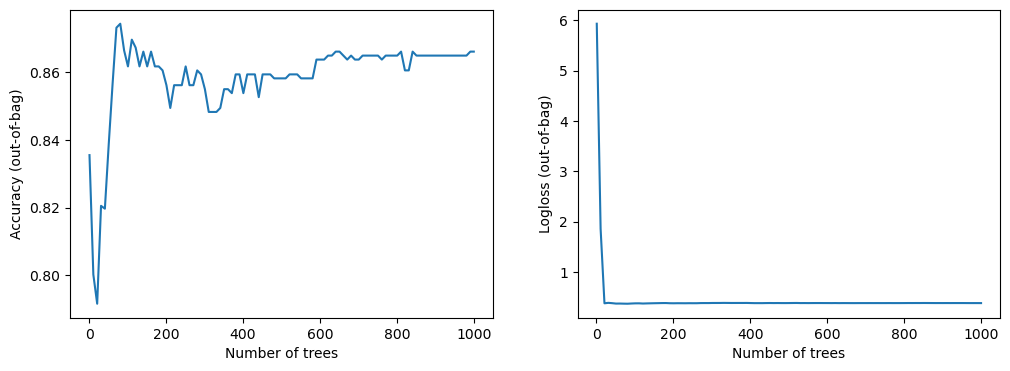


Train: 0.1878 Validation: 0.3083
##### Fold 2
Use /tmp/tmp1eu4ykdh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.075024. Found 514 examples.
Training model...
Model trained in 0:00:00.686834
Compiling model...


[INFO 23-07-21 07:48:55.1005 UTC kernel.cc:1242] Loading model from path /tmp/tmp1eu4ykdh/model/ with prefix fb21405b2f284469
[INFO 23-07-21 07:48:55.2326 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32686 node(s), and 113 input feature(s).
[INFO 23-07-21 07:48:55.2327 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 372ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8447 - balanced_log_loss: 0.4080


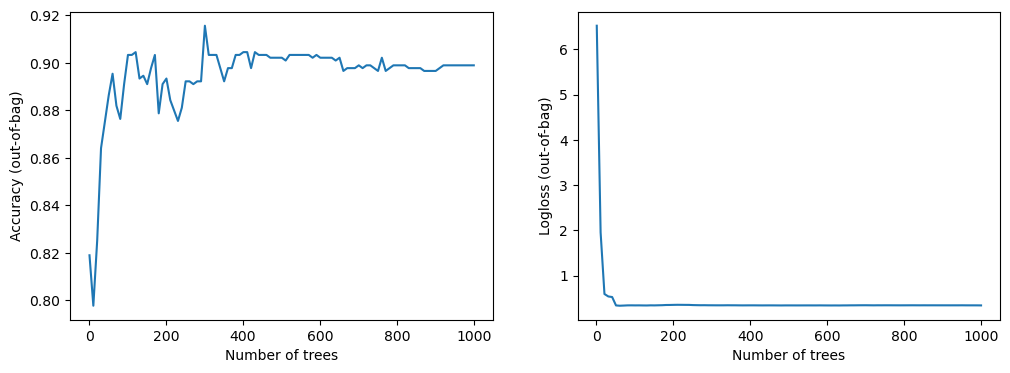


Train: 0.4765 Validation: 0.4080
##### Fold 3
Use /tmp/tmpwuvr27ao as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.088117. Found 514 examples.
Training model...
Model trained in 0:00:00.759119
Compiling model...


[INFO 23-07-21 07:49:02.5905 UTC kernel.cc:1242] Loading model from path /tmp/tmpwuvr27ao/model/ with prefix 1cabbffb22da4684
[INFO 23-07-21 07:49:02.7258 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33890 node(s), and 113 input feature(s).
[INFO 23-07-21 07:49:02.7259 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:49:02.7259 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 390ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3164


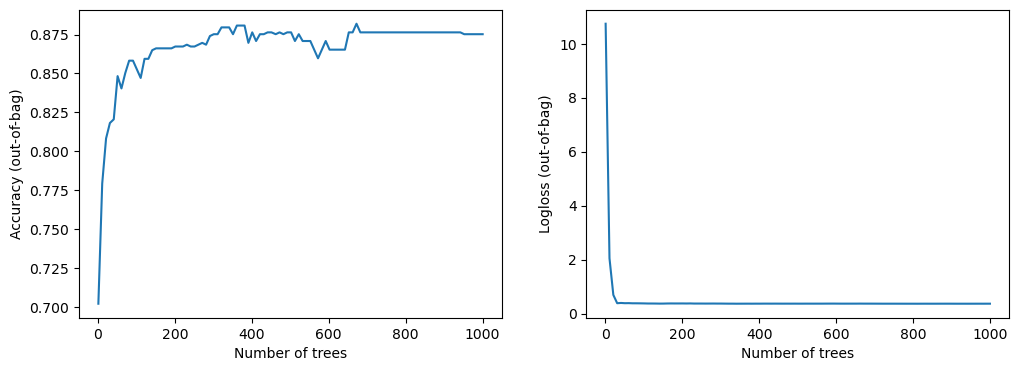


Train: 0.5861 Validation: 0.3164
##### Fold 4
Use /tmp/tmpmy7bmgcv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.150580. Found 514 examples.
Training model...
Model trained in 0:00:00.701159
Compiling model...


[INFO 23-07-21 07:49:10.1962 UTC kernel.cc:1242] Loading model from path /tmp/tmpmy7bmgcv/model/ with prefix a13584d5367a4474
[INFO 23-07-21 07:49:10.3272 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33338 node(s), and 112 input feature(s).
[INFO 23-07-21 07:49:10.3273 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3642


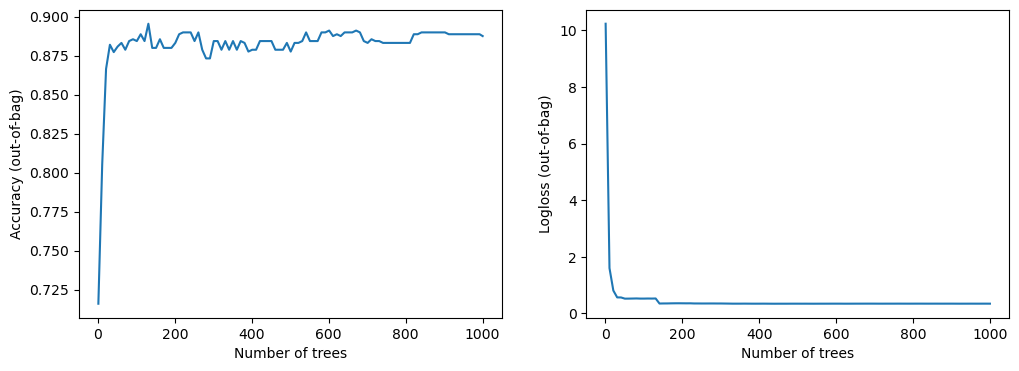


Train: 0.4843 Validation: 0.3642
##### Fold 5
Use /tmp/tmp57fdexld as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.149778. Found 514 examples.
Training model...
Model trained in 0:00:00.698620
Compiling model...


[INFO 23-07-21 07:49:17.7748 UTC kernel.cc:1242] Loading model from path /tmp/tmp57fdexld/model/ with prefix df7944354b804f96
[INFO 23-07-21 07:49:17.9062 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32930 node(s), and 113 input feature(s).
[INFO 23-07-21 07:49:17.9064 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:49:17.9065 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 396ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.4281


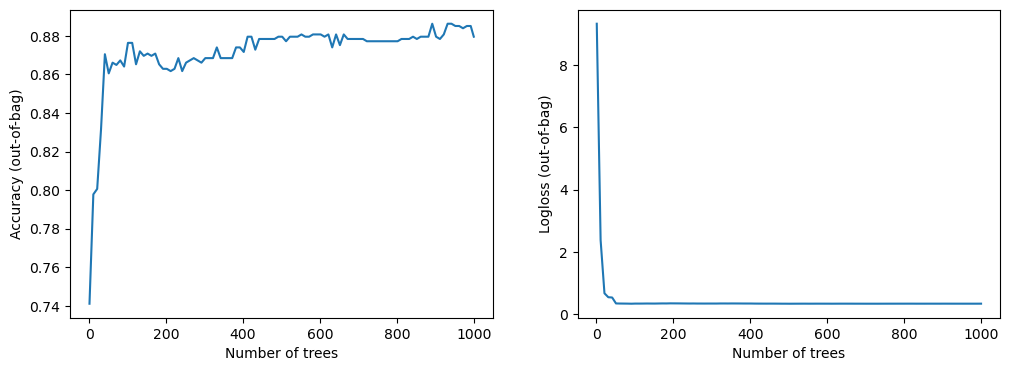


Train: 0.5298 Validation: 0.4281
##### Fold 6
Use /tmp/tmpxj2izn0s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.104068. Found 515 examples.
Training model...
Model trained in 0:00:00.707695
Compiling model...


[INFO 23-07-21 07:49:26.0620 UTC kernel.cc:1242] Loading model from path /tmp/tmpxj2izn0s/model/ with prefix 77ff6fefa9334bc1
[INFO 23-07-21 07:49:26.1979 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33646 node(s), and 113 input feature(s).
[INFO 23-07-21 07:49:26.1981 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9706 - balanced_log_loss: 0.2618


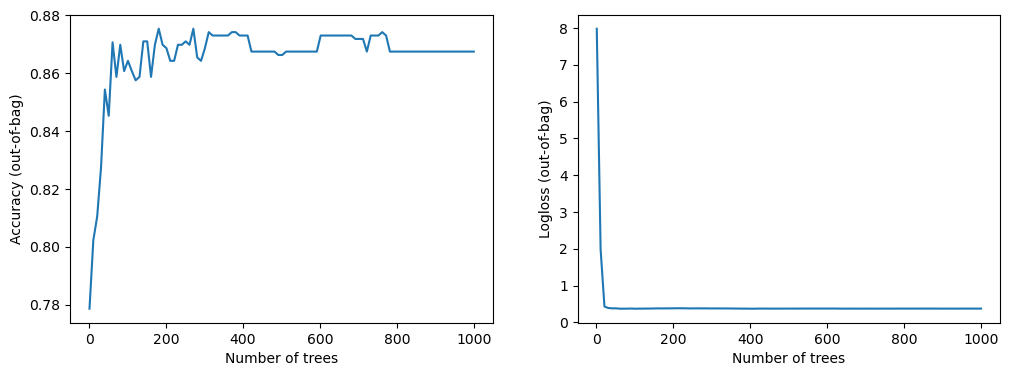


Train: 0.6131 Validation: 0.2618

Train mean: 0.4796 std: 0.1529

Validation mean: 0.3478 std: 0.0637


In [16]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_1, valid_summary_rf_1, test_summary_rf_1, model_rf_1,metrics_rf_1 = train_model(
        train=train_out,test=test_out, features=features,
        n_splits=6,
        model_obj=tfdf.keras.RandomForestModel,
        model_kwargs=dict(max_depth=6, num_trees=1000),
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpy3vglma1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.178034. Found 555 examples.
Training model...
Model trained in 0:00:00.233148
Compiling model...


[INFO 23-07-21 07:49:38.7579 UTC kernel.cc:1242] Loading model from path /tmp/tmpy3vglma1/model/ with prefix e3594c015e374837
[INFO 23-07-21 07:49:38.7985 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-21 07:49:38.7986 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:49:38.7986 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3015


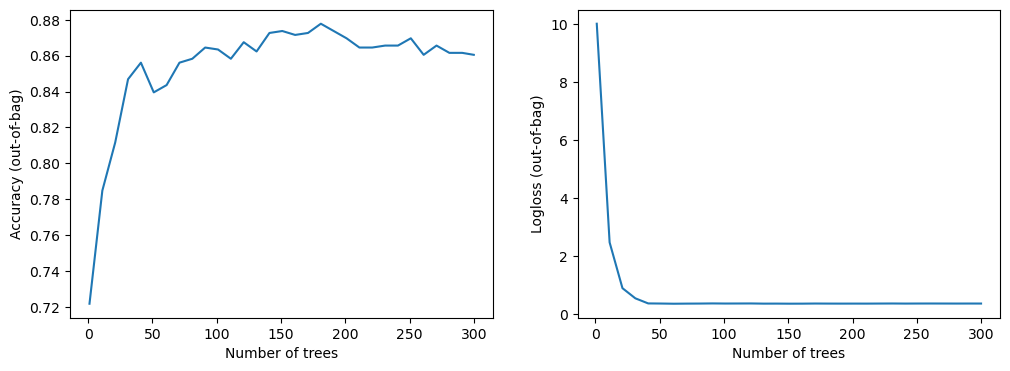


Train: 0.1855 Validation: 0.3015
##### Fold 2
Use /tmp/tmp4acu2oq1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.080701. Found 555 examples.
Training model...
Model trained in 0:00:00.236634
Compiling model...


[INFO 23-07-21 07:49:45.6494 UTC kernel.cc:1242] Loading model from path /tmp/tmp4acu2oq1/model/ with prefix 0251279d6d28445f
[INFO 23-07-21 07:49:45.6906 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-21 07:49:45.6907 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 377ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3116


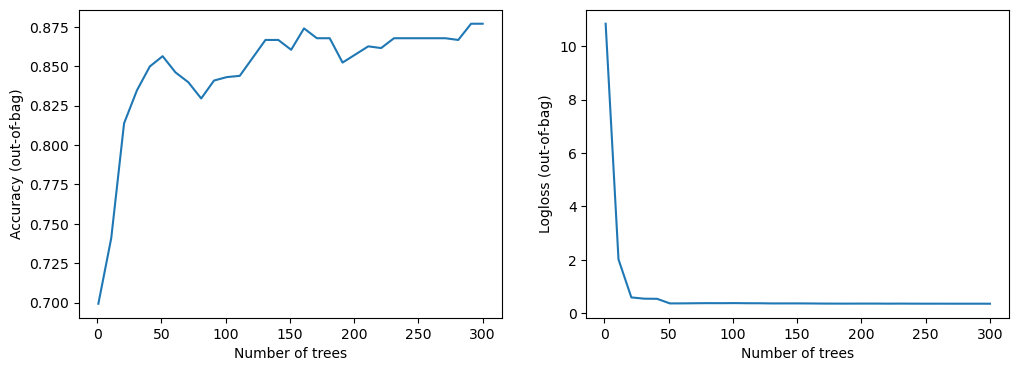


Train: 0.4840 Validation: 0.3116
##### Fold 3
Use /tmp/tmpxb36bf2l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.138011. Found 555 examples.
Training model...
Model trained in 0:00:00.235590
Compiling model...


[INFO 23-07-21 07:49:53.7157 UTC kernel.cc:1242] Loading model from path /tmp/tmpxb36bf2l/model/ with prefix 1c5e35c703cc421b
[INFO 23-07-21 07:49:53.7581 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-21 07:49:53.7583 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:49:53.7585 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_log_loss: 0.4417


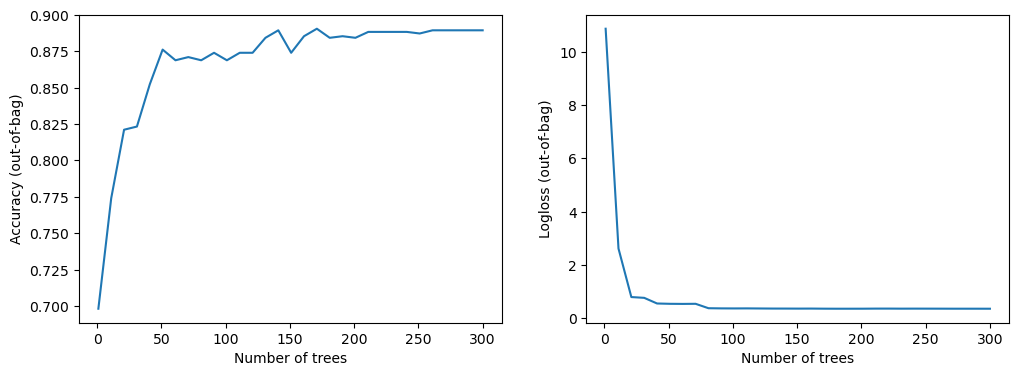


Train: 0.4848 Validation: 0.4417
##### Fold 4
Use /tmp/tmpw6w5qiyl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.090079. Found 555 examples.
Training model...
Model trained in 0:00:00.236726
Compiling model...


[INFO 23-07-21 07:50:00.6563 UTC kernel.cc:1242] Loading model from path /tmp/tmpw6w5qiyl/model/ with prefix e2c9c94565764eaf
[INFO 23-07-21 07:50:00.6972 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-21 07:50:00.6973 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 369ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_log_loss: 0.3305


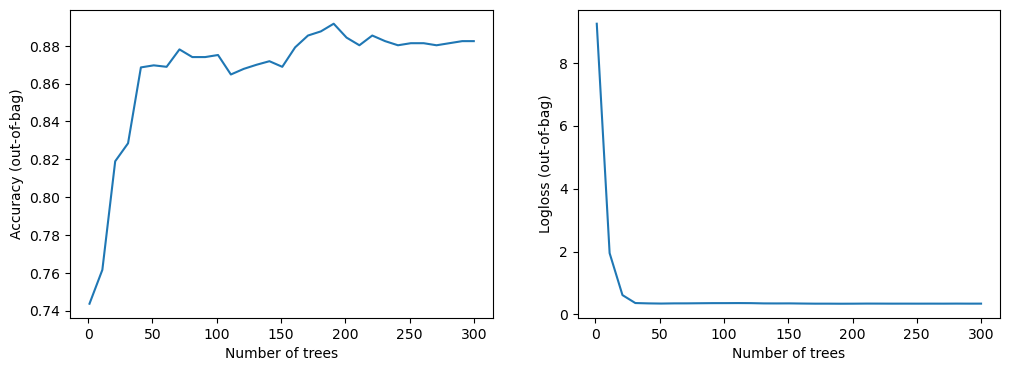


Train: 0.6168 Validation: 0.3305
##### Fold 5
Use /tmp/tmpefmo8h16 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.051441. Found 555 examples.
Training model...
Model trained in 0:00:00.241907
Compiling model...


[INFO 23-07-21 07:50:07.5891 UTC kernel.cc:1242] Loading model from path /tmp/tmpefmo8h16/model/ with prefix d7fb8bb8b42f4c0f
[INFO 23-07-21 07:50:07.6311 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:07.6312 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:50:07.6312 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3279


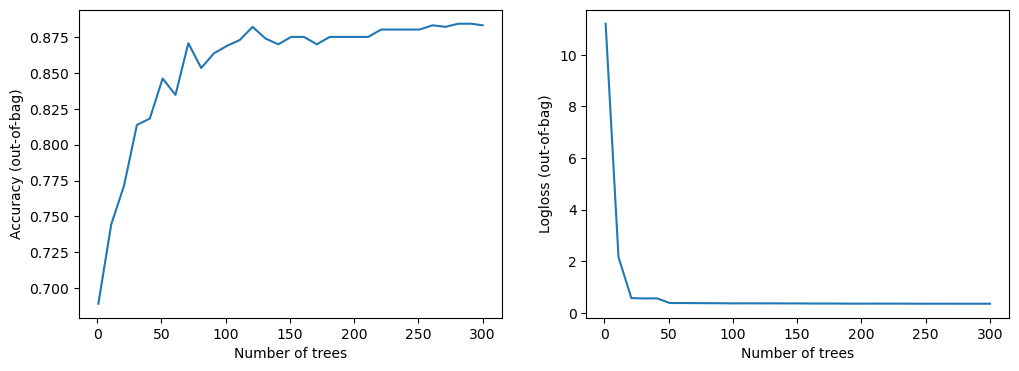


Train: 0.5066 Validation: 0.3279
##### Fold 6
Use /tmp/tmpu2team4u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.058035. Found 555 examples.
Training model...
Model trained in 0:00:00.234902
Compiling model...


[INFO 23-07-21 07:50:15.6278 UTC kernel.cc:1242] Loading model from path /tmp/tmpu2team4u/model/ with prefix 23068d223a904dd0
[INFO 23-07-21 07:50:15.6687 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:15.6688 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3564


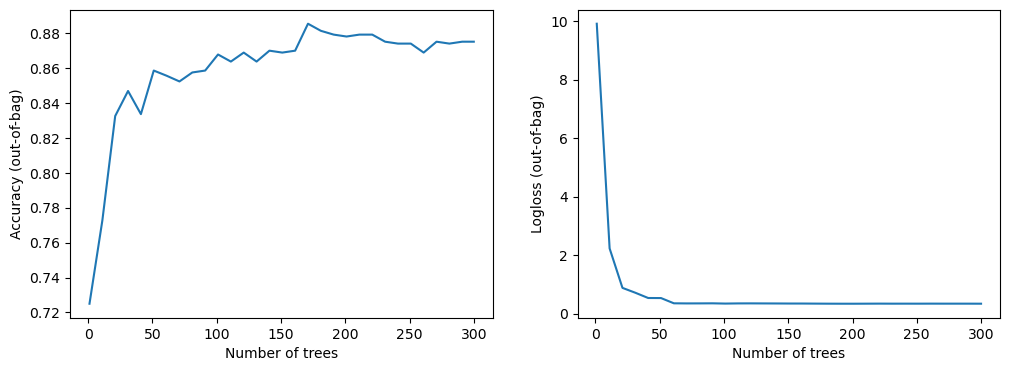


Train: 0.5020 Validation: 0.3564
##### Fold 7
Use /tmp/tmpuiiya0wm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.105386. Found 555 examples.
Training model...
Model trained in 0:00:00.233636
Compiling model...


[INFO 23-07-21 07:50:23.4500 UTC kernel.cc:1242] Loading model from path /tmp/tmpuiiya0wm/model/ with prefix 7cb228f80f074630
[INFO 23-07-21 07:50:23.4921 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:23.4921 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:50:23.4921 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 364ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4016


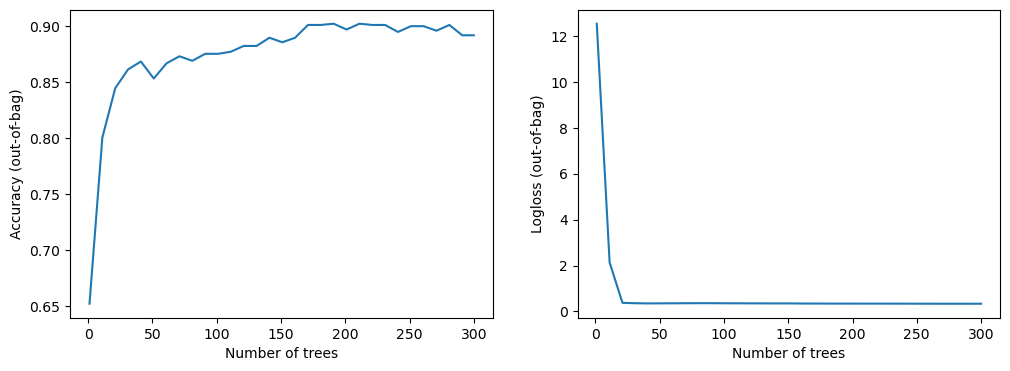


Train: 0.5269 Validation: 0.4016
##### Fold 8
Use /tmp/tmpo8p33yrt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.026923. Found 556 examples.
Training model...
Model trained in 0:00:00.233957
Compiling model...


[INFO 23-07-21 07:50:30.1924 UTC kernel.cc:1242] Loading model from path /tmp/tmpo8p33yrt/model/ with prefix 7d4ad8e79d4b48ee
[INFO 23-07-21 07:50:30.2341 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:30.2342 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 358ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.3344


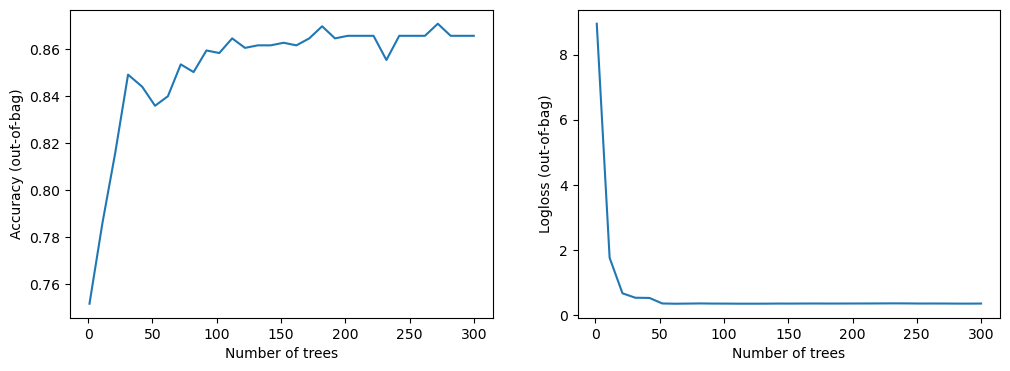


Train: 0.5754 Validation: 0.3344
##### Fold 9
Use /tmp/tmpeul4uutc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.001463. Found 556 examples.
Training model...
Model trained in 0:00:00.237398
Compiling model...


[INFO 23-07-21 07:50:36.8264 UTC kernel.cc:1242] Loading model from path /tmp/tmpeul4uutc/model/ with prefix 1e0020fcb69e478b
[INFO 23-07-21 07:50:36.8679 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:36.8682 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:50:36.8683 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 369ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.4160


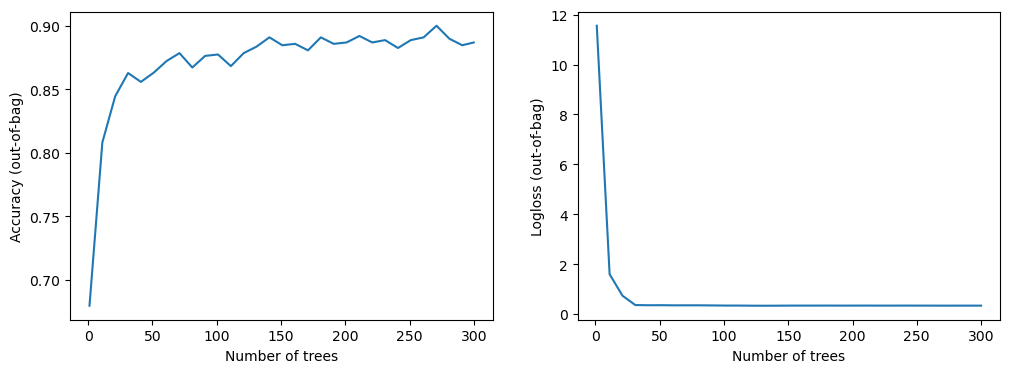


Train: 0.5072 Validation: 0.4160
##### Fold 10
Use /tmp/tmpdvh8475z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.033526. Found 556 examples.
Training model...
Model trained in 0:00:00.232752
Compiling model...


[INFO 23-07-21 07:50:44.7085 UTC kernel.cc:1242] Loading model from path /tmp/tmpdvh8475z/model/ with prefix 5a0fe0dcb5b641cf
[INFO 23-07-21 07:50:44.7501 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-21 07:50:44.7502 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 359ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2804


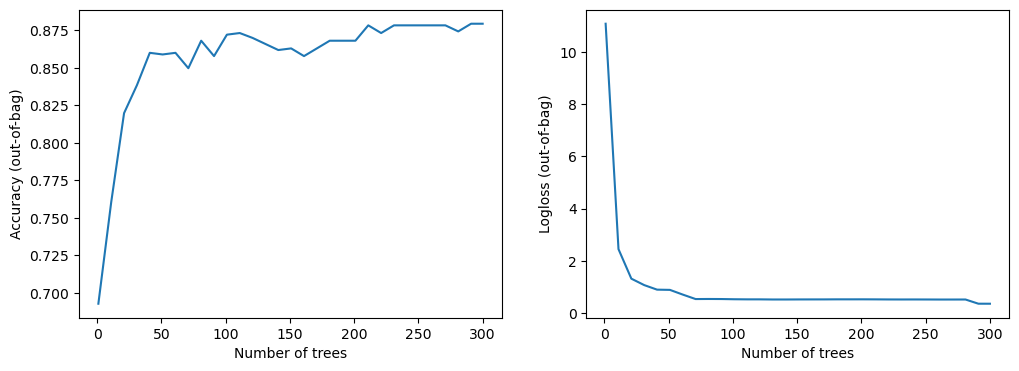


Train: 0.5957 Validation: 0.2804

Train mean: 0.4985 std: 0.1196

Validation mean: 0.3502 std: 0.0530


In [17]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_2, valid_summary_rf_2, test_summary_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpx9vbz1kg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.200317. Found 555 examples.
Training model...
Model trained in 0:00:00.183123
Compiling model...


[INFO 23-07-21 07:50:50.4192 UTC kernel.cc:1242] Loading model from path /tmp/tmpx9vbz1kg/model/ with prefix 01f1939de7a8462a
[INFO 23-07-21 07:50:50.4637 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-21 07:50:50.4638 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:50:50.4638 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2470


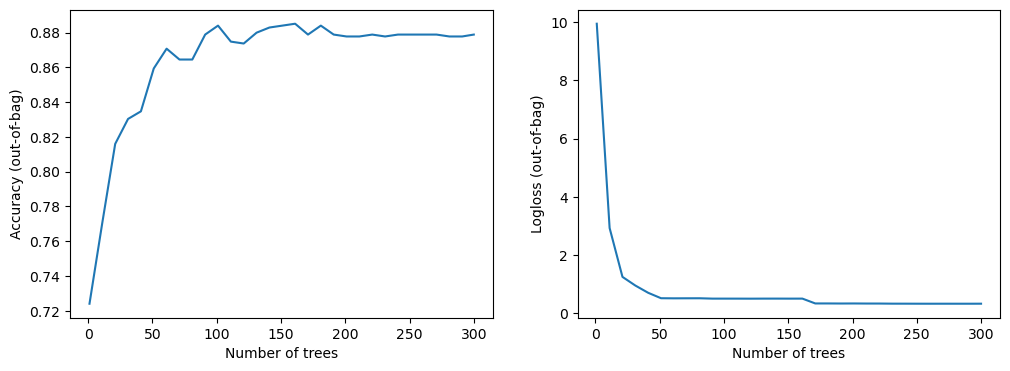


Train: 0.2012 Validation: 0.2470
##### Fold 2
Use /tmp/tmp5fr3fai7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.199019. Found 555 examples.
Training model...
Model trained in 0:00:00.181858
Compiling model...


[INFO 23-07-21 07:50:54.8162 UTC kernel.cc:1242] Loading model from path /tmp/tmp5fr3fai7/model/ with prefix a5778a580a15426a
[INFO 23-07-21 07:50:54.8602 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 07:50:54.8603 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2757


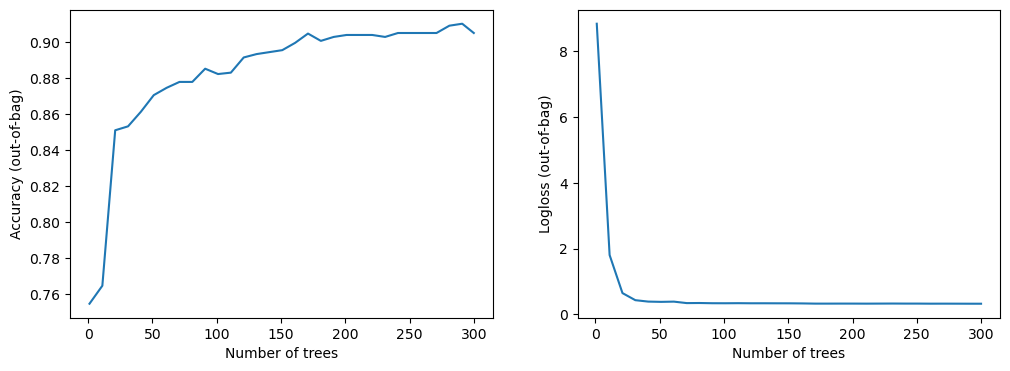


Train: 0.4433 Validation: 0.2757
##### Fold 3
Use /tmp/tmpfkv_21x2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.213623. Found 555 examples.
Training model...
Model trained in 0:00:00.181447
Compiling model...


[INFO 23-07-21 07:50:59.2830 UTC kernel.cc:1242] Loading model from path /tmp/tmpfkv_21x2/model/ with prefix 57349b1fed004824
[INFO 23-07-21 07:50:59.3264 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-21 07:50:59.3264 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3758


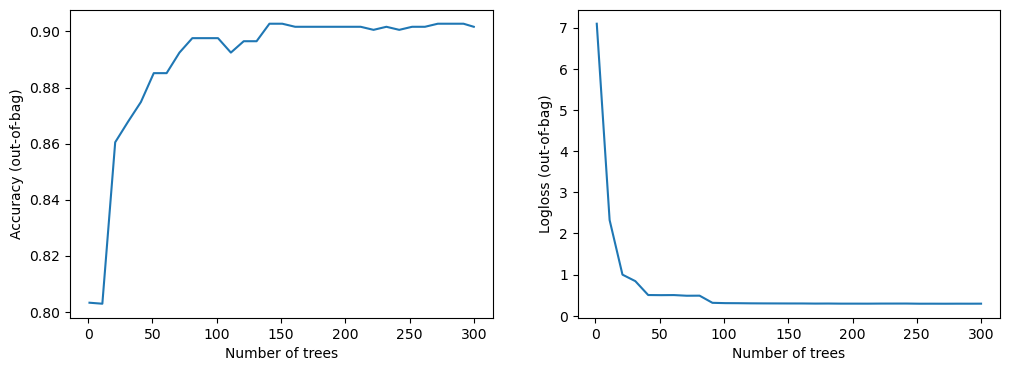


Train: 0.4615 Validation: 0.3758
##### Fold 4
Use /tmp/tmpzl4jco02 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.199024. Found 555 examples.
Training model...
Model trained in 0:00:00.182470
Compiling model...


[INFO 23-07-21 07:51:03.6064 UTC kernel.cc:1242] Loading model from path /tmp/tmpzl4jco02/model/ with prefix 04299c4e21154385
[INFO 23-07-21 07:51:03.6513 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:03.6514 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:51:03.6514 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3001


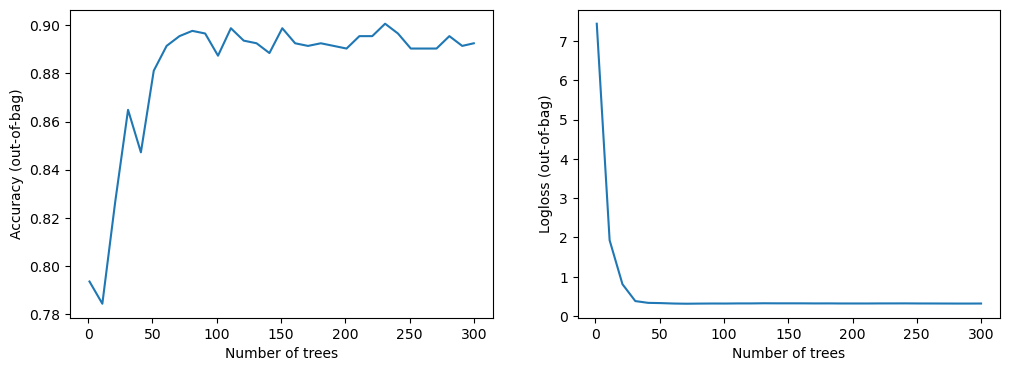


Train: 0.5660 Validation: 0.3001
##### Fold 5
Use /tmp/tmplq3dj3ve as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.253868. Found 555 examples.
Training model...
Model trained in 0:00:00.186688
Compiling model...


[INFO 23-07-21 07:51:08.8143 UTC kernel.cc:1242] Loading model from path /tmp/tmplq3dj3ve/model/ with prefix 4b75541663724baa
[INFO 23-07-21 07:51:08.8586 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:08.8587 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2855


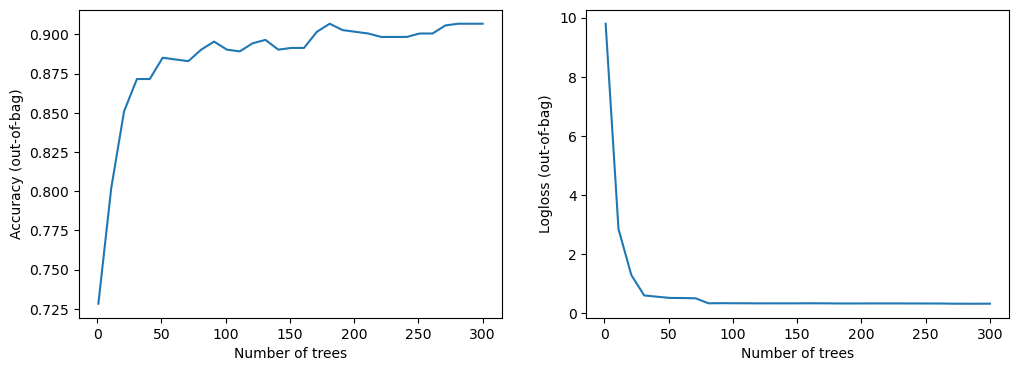


Train: 0.4859 Validation: 0.2855
##### Fold 6
Use /tmp/tmpv62enn62 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.255911. Found 555 examples.
Training model...
Model trained in 0:00:00.184974
Compiling model...


[INFO 23-07-21 07:51:13.2262 UTC kernel.cc:1242] Loading model from path /tmp/tmpv62enn62/model/ with prefix a0f1da5915ef4cf3
[INFO 23-07-21 07:51:13.2706 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:13.2707 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3069


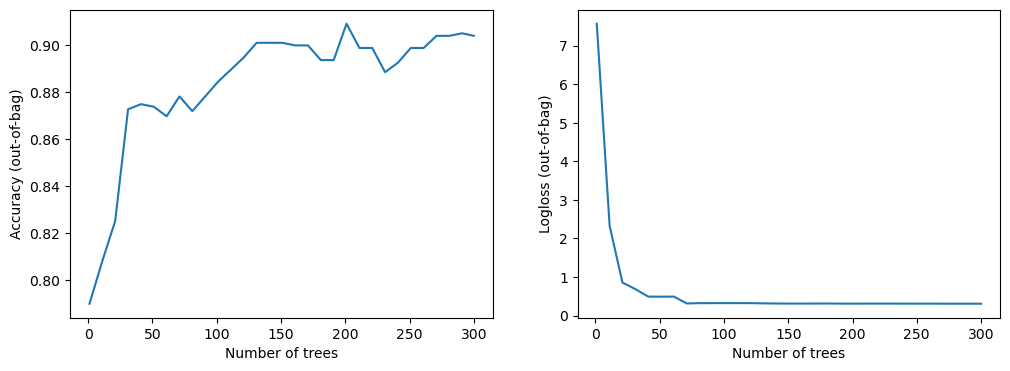


Train: 0.4704 Validation: 0.3069
##### Fold 7
Use /tmp/tmpty4qx54c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.246248. Found 555 examples.
Training model...
Model trained in 0:00:00.183702
Compiling model...


[INFO 23-07-21 07:51:17.6832 UTC kernel.cc:1242] Loading model from path /tmp/tmpty4qx54c/model/ with prefix cde1289df186475c
[INFO 23-07-21 07:51:17.7283 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-21 07:51:17.7284 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:51:17.7284 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3602


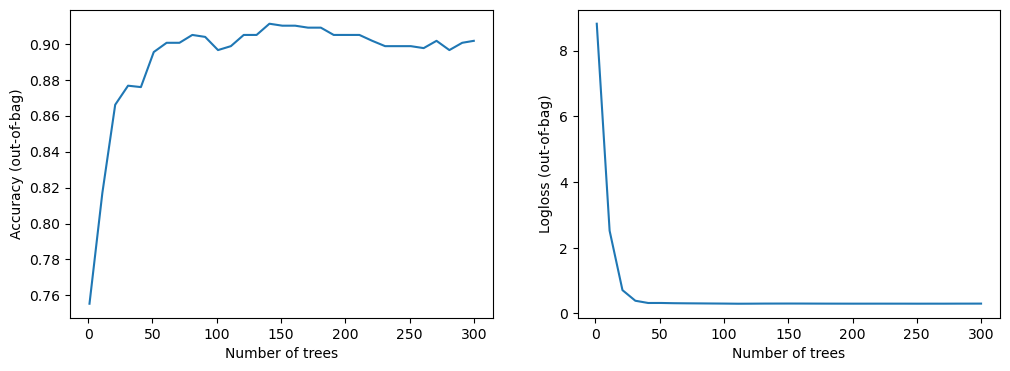


Train: 0.4883 Validation: 0.3602
##### Fold 8
Use /tmp/tmpjxsz_upm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.215456. Found 556 examples.
Training model...
Model trained in 0:00:00.194928
Compiling model...


[INFO 23-07-21 07:51:22.1057 UTC kernel.cc:1242] Loading model from path /tmp/tmpjxsz_upm/model/ with prefix c7c4c9dc2ea54c33
[INFO 23-07-21 07:51:22.1561 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:22.1562 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.3318


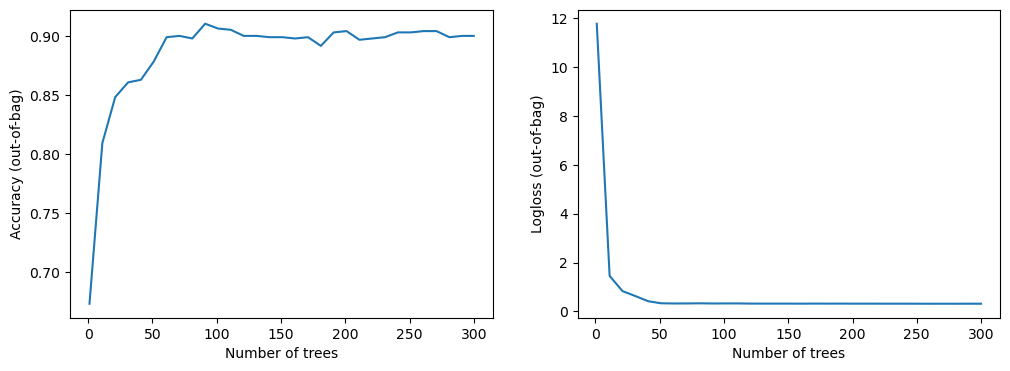


Train: 0.5488 Validation: 0.3318
##### Fold 9
Use /tmp/tmpg8og2nkc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.245989. Found 556 examples.
Training model...
Model trained in 0:00:00.187079
Compiling model...


[INFO 23-07-21 07:51:26.6573 UTC kernel.cc:1242] Loading model from path /tmp/tmpg8og2nkc/model/ with prefix cd19686a2fa84e0f
[INFO 23-07-21 07:51:26.7009 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:26.7009 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3449


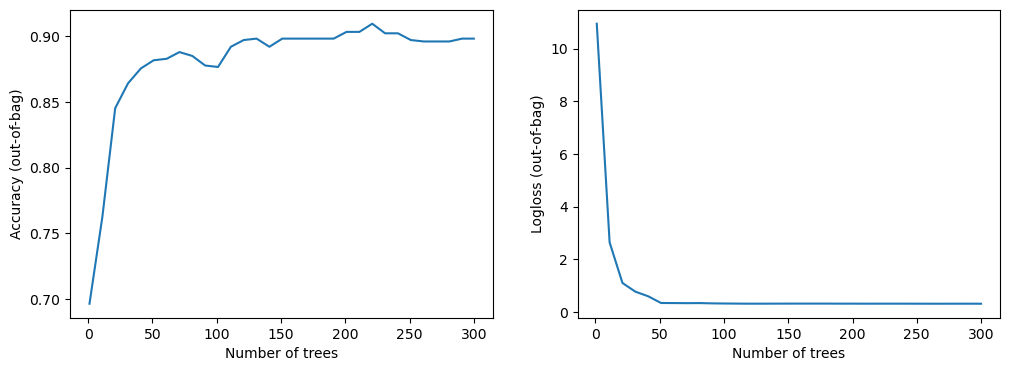


Train: 0.5168 Validation: 0.3449
##### Fold 10
Use /tmp/tmpudhbhp90 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.223828. Found 556 examples.
Training model...
Model trained in 0:00:00.185509
Compiling model...


[INFO 23-07-21 07:51:31.1937 UTC kernel.cc:1242] Loading model from path /tmp/tmpudhbhp90/model/ with prefix 9cd8b19566b048c6
[INFO 23-07-21 07:51:31.2382 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-21 07:51:31.2384 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 07:51:31.2384 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.2687


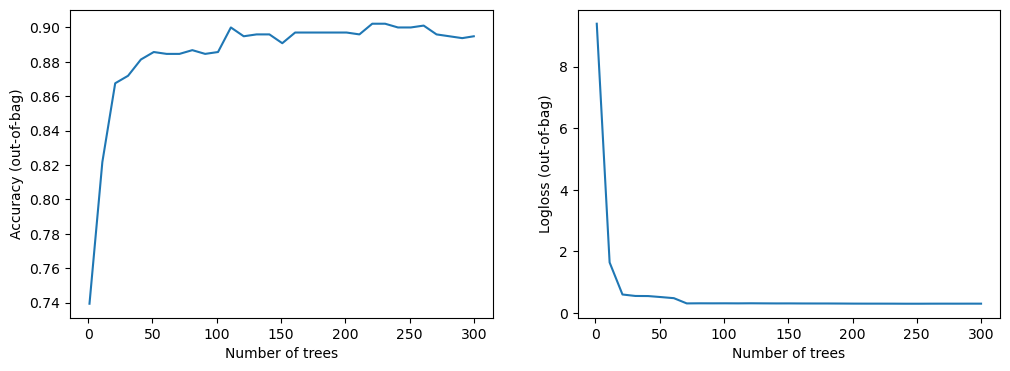


Train: 0.5330 Validation: 0.2687

Train mean: 0.4715 std: 0.1028

Validation mean: 0.3096 std: 0.0423


In [18]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp1jufcl4k as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:51:34.4224 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:34.4225 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:34.4225 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.237490. Found 555 examples.
Training model...
Model trained in 0:00:01.952499
Compiling model...


[INFO 23-07-21 07:51:37.6013 UTC kernel.cc:1242] Loading model from path /tmp/tmp1jufcl4k/model/ with prefix d07d989d472e456b
[INFO 23-07-21 07:51:37.6213 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 0.0299


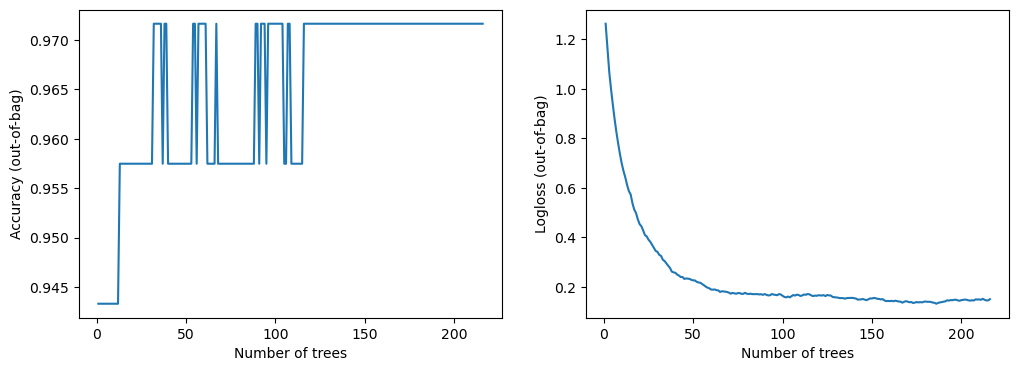


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmpd33ywzhn as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:51:43.1378 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:43.1379 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:43.1379 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.218029. Found 555 examples.
Training model...
Model trained in 0:00:01.773269
Compiling model...


[INFO 23-07-21 07:51:46.1189 UTC kernel.cc:1242] Loading model from path /tmp/tmpd33ywzhn/model/ with prefix b14654b0f9614c4b
[INFO 23-07-21 07:51:46.1378 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:51:46.1378 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1438


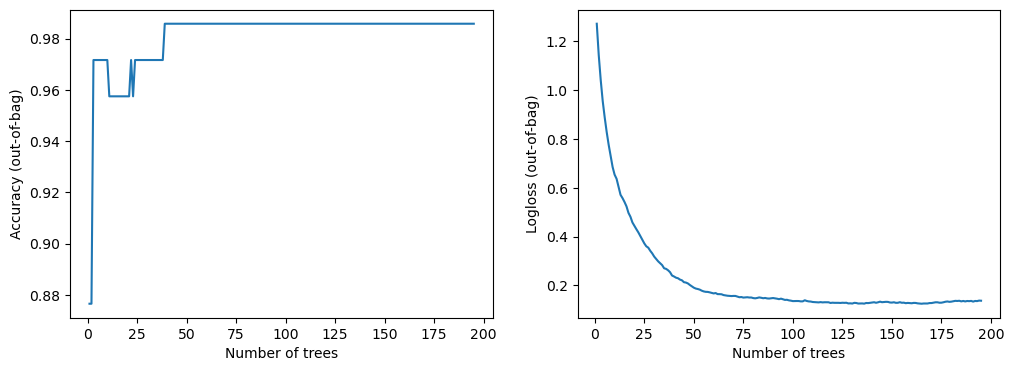


Train: 0.0360 Validation: 0.1438
##### Fold 3
Use /tmp/tmpnzlt3dc3 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:51:49.1728 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:49.1728 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:49.1729 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.218993. Found 555 examples.
Training model...
Model trained in 0:00:02.373768
Compiling model...


[INFO 23-07-21 07:51:52.7488 UTC kernel.cc:1242] Loading model from path /tmp/tmpnzlt3dc3/model/ with prefix 45ce093cb0a24289
[INFO 23-07-21 07:51:52.7733 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.8838


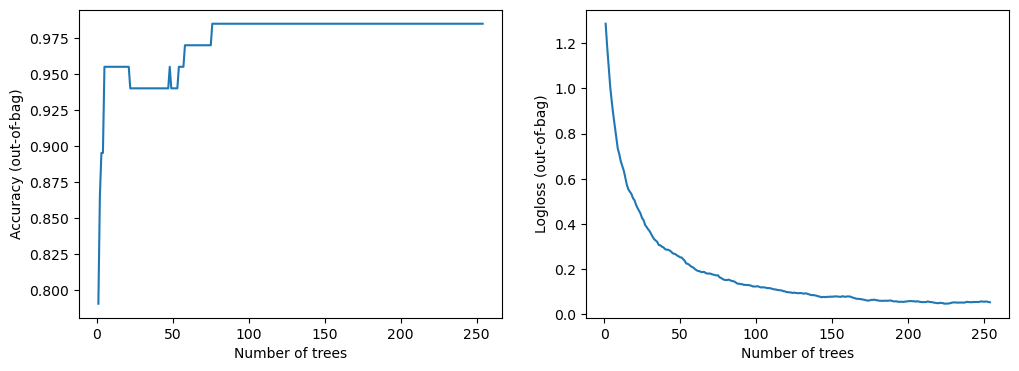


Train: 0.1457 Validation: 0.8838
##### Fold 4
Use /tmp/tmpr7ah2a9h as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:51:55.8318 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:55.8319 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:51:55.8319 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.233289. Found 555 examples.
Training model...
Model trained in 0:00:02.498575
Compiling model...


[INFO 23-07-21 07:51:59.5460 UTC kernel.cc:1242] Loading model from path /tmp/tmpr7ah2a9h/model/ with prefix ff466f3a9a4e41d9
[INFO 23-07-21 07:51:59.5716 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:51:59.5717 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3553


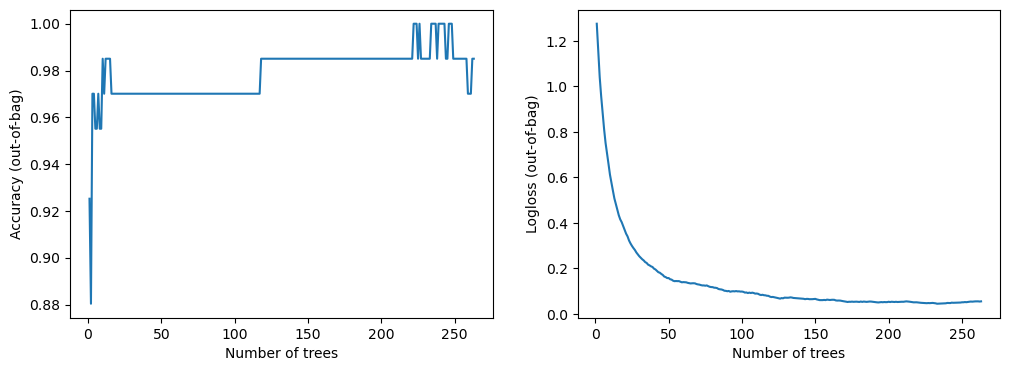


Train: 0.8856 Validation: 0.3553
##### Fold 5
Use /tmp/tmps_yc0h7i as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:04.5726 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:04.5726 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:04.5727 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.244200. Found 555 examples.
Training model...
Model trained in 0:00:02.540301
Compiling model...


[INFO 23-07-21 07:52:08.3376 UTC kernel.cc:1242] Loading model from path /tmp/tmps_yc0h7i/model/ with prefix 70eed9b01bfd4a6f
[INFO 23-07-21 07:52:08.3644 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.5371


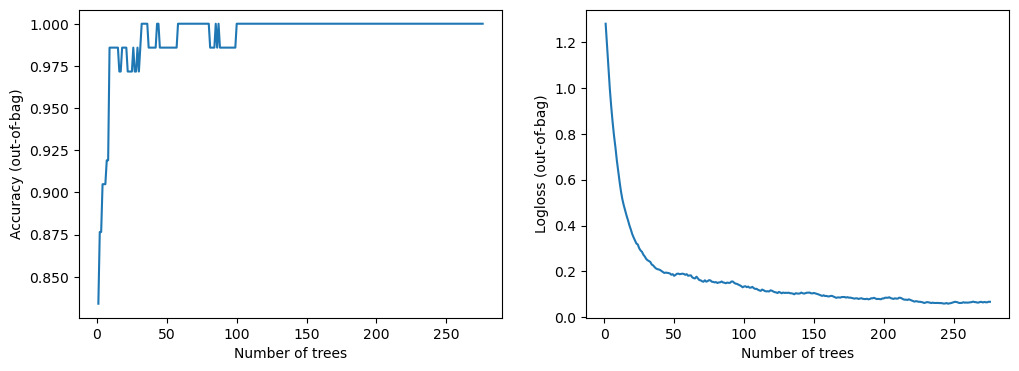


Train: 0.3576 Validation: 0.5371
##### Fold 6
Use /tmp/tmp7ojdpizx as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:11.4237 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:11.4237 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:11.4238 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.267509. Found 555 examples.
Training model...
Model trained in 0:00:01.318297
Compiling model...


[INFO 23-07-21 07:52:14.0064 UTC kernel.cc:1242] Loading model from path /tmp/tmp7ojdpizx/model/ with prefix aeed889bbf7248f2
[INFO 23-07-21 07:52:14.0186 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:52:14.0187 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2998


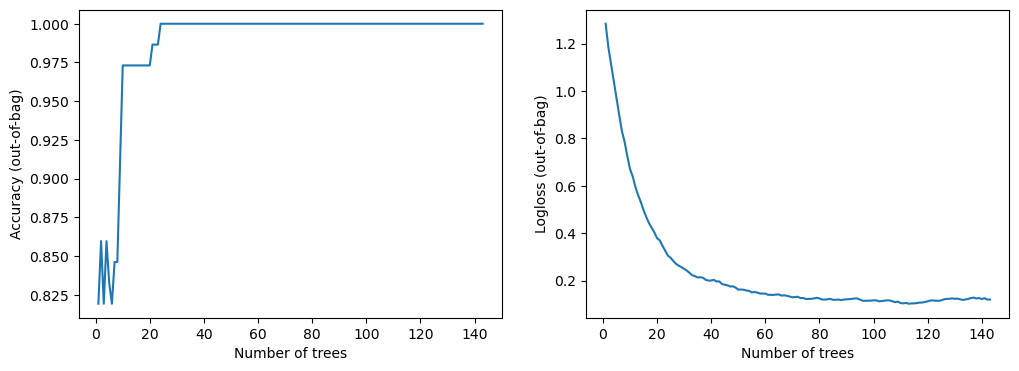


Train: 0.5467 Validation: 0.2998
##### Fold 7
Use /tmp/tmp6hbyezxu as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:18.5980 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:18.5980 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:18.5981 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.274969. Found 555 examples.
Training model...
Model trained in 0:00:00.584105
Compiling model...


[INFO 23-07-21 07:52:20.4621 UTC kernel.cc:1242] Loading model from path /tmp/tmp6hbyezxu/model/ with prefix 6facd84b448f475b
[INFO 23-07-21 07:52:20.4668 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 275ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3052


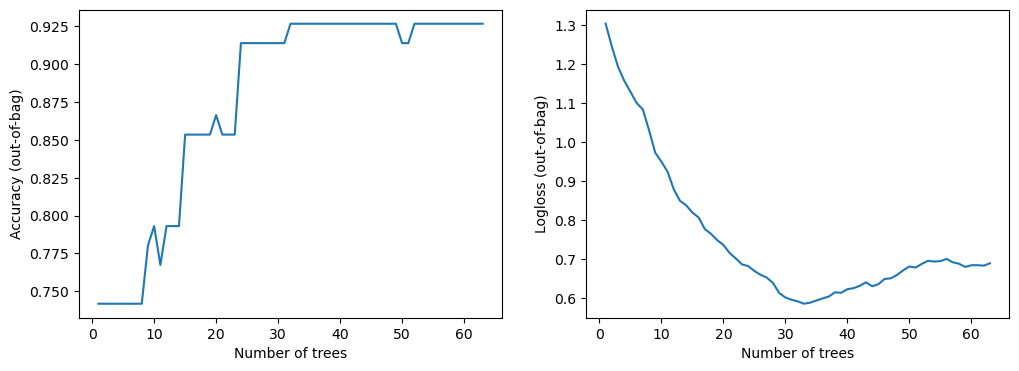


Train: 0.4053 Validation: 0.3052
##### Fold 8
Use /tmp/tmpd3iy8c3a as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:23.5764 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:23.5764 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:23.5764 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.223779. Found 556 examples.
Training model...
Model trained in 0:00:00.612744
Compiling model...


[INFO 23-07-21 07:52:25.4165 UTC kernel.cc:1242] Loading model from path /tmp/tmpd3iy8c3a/model/ with prefix 92fbc0a9d28c4875
[INFO 23-07-21 07:52:25.4211 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:52:25.4211 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3190


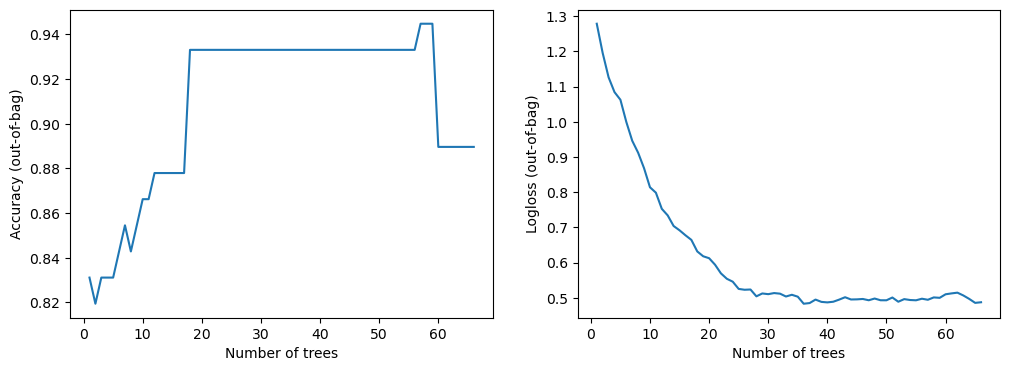


Train: 0.4007 Validation: 0.3190
##### Fold 9
Use /tmp/tmpwfh0cz12 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:28.5379 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:28.5380 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:28.5380 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.248784. Found 556 examples.
Training model...
Model trained in 0:00:01.040263
Compiling model...


[INFO 23-07-21 07:52:30.8261 UTC kernel.cc:1242] Loading model from path /tmp/tmpwfh0cz12/model/ with prefix b6739d5b2ab44cab
[INFO 23-07-21 07:52:30.8362 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4456


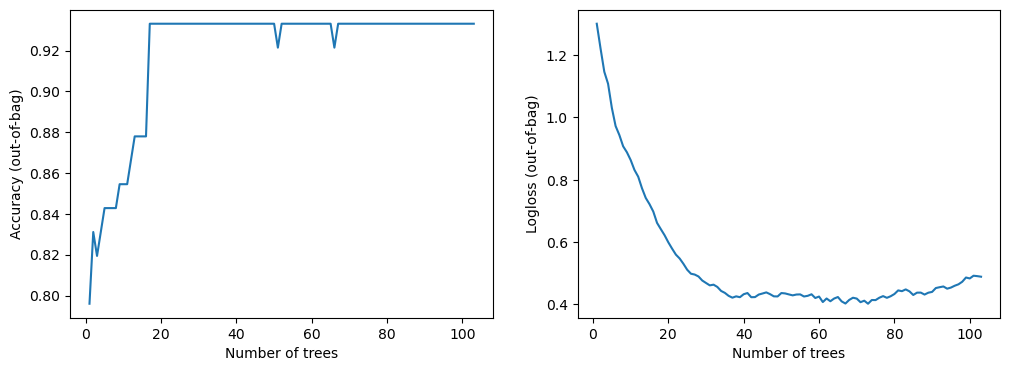


Train: 0.3539 Validation: 0.4456
##### Fold 10
Use /tmp/tmpuh1p0pyj as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:34.6877 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:34.6877 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:34.6877 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.226497. Found 556 examples.
Training model...
Model trained in 0:00:00.595491
Compiling model...


[INFO 23-07-21 07:52:36.5136 UTC kernel.cc:1242] Loading model from path /tmp/tmpuh1p0pyj/model/ with prefix 33b227943fca486b
[INFO 23-07-21 07:52:36.5183 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:52:36.5184 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.2912


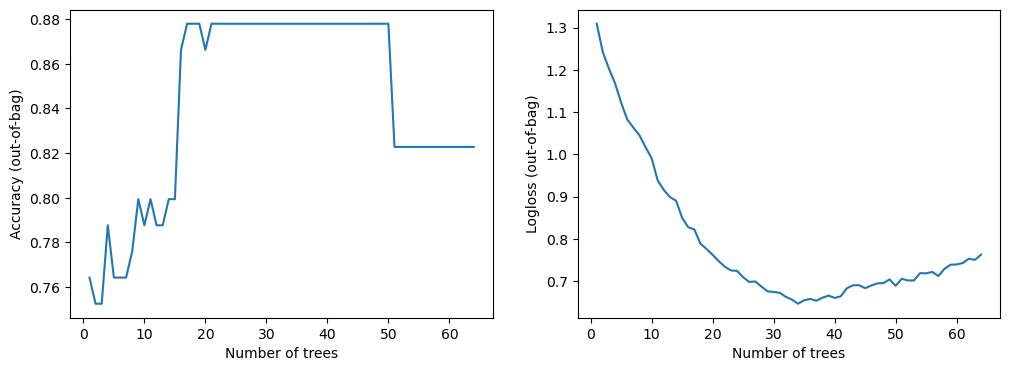


Train: 0.5554 Validation: 0.2912

Train mean: 0.3693 std: 0.2642

Validation mean: 0.3611 std: 0.2314


In [19]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    train_summary_gbt_1, valid_summary_gbt_1, test_summary_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp7sabg5hx as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:39.6408 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:39.6408 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:39.6408 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.226570. Found 555 examples.
Training model...
Model trained in 0:00:00.999555
Compiling model...


[INFO 23-07-21 07:52:41.8667 UTC kernel.cc:1242] Loading model from path /tmp/tmp7sabg5hx/model/ with prefix 481cdabf6d54477f
[INFO 23-07-21 07:52:41.8769 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1640


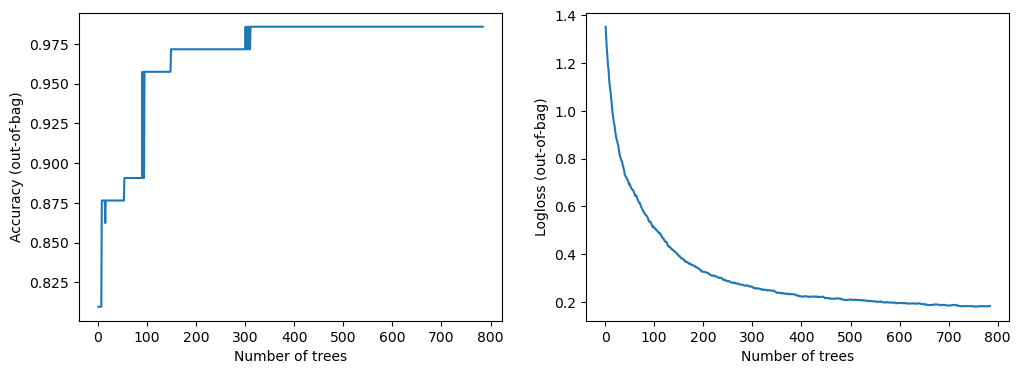


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmpgjx_2jw3 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:44.9872 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:44.9873 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:44.9873 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.233898. Found 555 examples.
Training model...
Model trained in 0:00:00.634255
Compiling model...


[INFO 23-07-21 07:52:46.8570 UTC kernel.cc:1242] Loading model from path /tmp/tmpgjx_2jw3/model/ with prefix c0a5e319660a485e
[INFO 23-07-21 07:52:46.8635 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:52:46.8635 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.1576


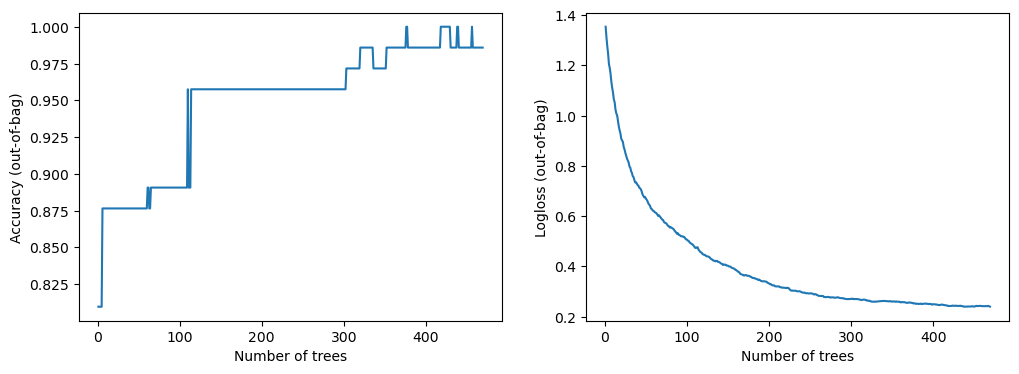


Train: 0.3058 Validation: 0.1576
##### Fold 3
Use /tmp/tmpkehwx7st as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:51.0934 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:51.0937 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:51.0939 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.249278. Found 555 examples.
Training model...
Model trained in 0:00:00.722753
Compiling model...


[INFO 23-07-21 07:52:53.0659 UTC kernel.cc:1242] Loading model from path /tmp/tmpkehwx7st/model/ with prefix 2dc2305368e643f6
[INFO 23-07-21 07:52:53.0734 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3384


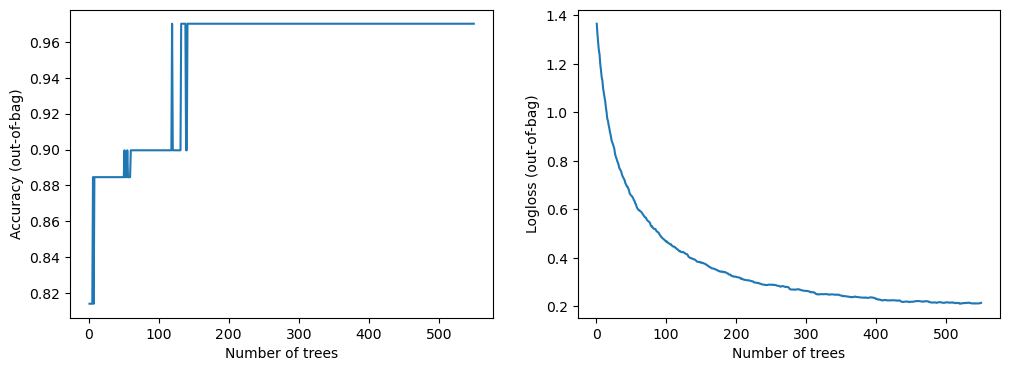


Train: 0.2765 Validation: 0.3384
##### Fold 4
Use /tmp/tmpeduv3dxu as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:52:56.1103 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:56.1104 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:52:56.1104 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.248487. Found 555 examples.
Training model...
Model trained in 0:00:00.642176
Compiling model...


[INFO 23-07-21 07:52:58.0031 UTC kernel.cc:1242] Loading model from path /tmp/tmpeduv3dxu/model/ with prefix 55802b215bb54f87
[INFO 23-07-21 07:52:58.0098 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:52:58.0099 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2671


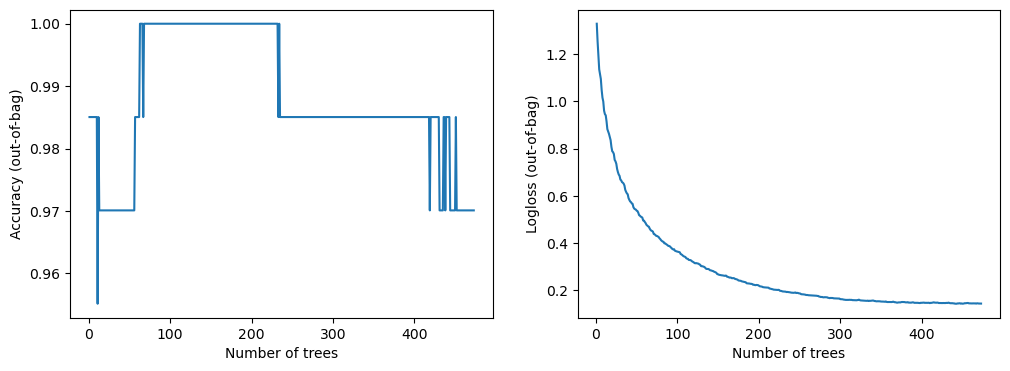


Train: 0.4713 Validation: 0.2671
##### Fold 5
Use /tmp/tmpnl8oia7x as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:00.9954 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:00.9954 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:00.9954 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.541771. Found 555 examples.
Training model...
Model trained in 0:00:00.995543
Compiling model...


[INFO 23-07-21 07:53:03.5320 UTC kernel.cc:1242] Loading model from path /tmp/tmpnl8oia7x/model/ with prefix ac3cae9abef34433
[INFO 23-07-21 07:53:03.5419 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2613


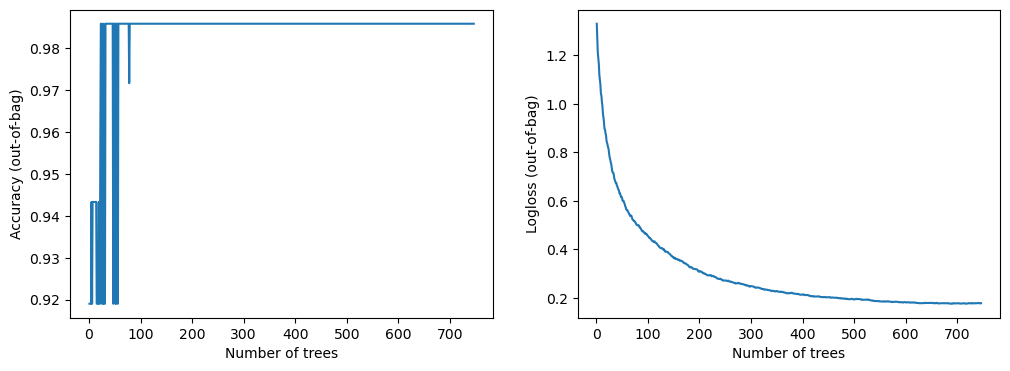


Train: 0.3730 Validation: 0.2613
##### Fold 6
Use /tmp/tmpbzra_x7b as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:06.6001 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:06.6002 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:06.6002 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.268659. Found 555 examples.
Training model...
Model trained in 0:00:01.183422
Compiling model...


[INFO 23-07-21 07:53:09.0497 UTC kernel.cc:1242] Loading model from path /tmp/tmpbzra_x7b/model/ with prefix c9f2a18348224820
[INFO 23-07-21 07:53:09.0612 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:53:09.0612 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2744


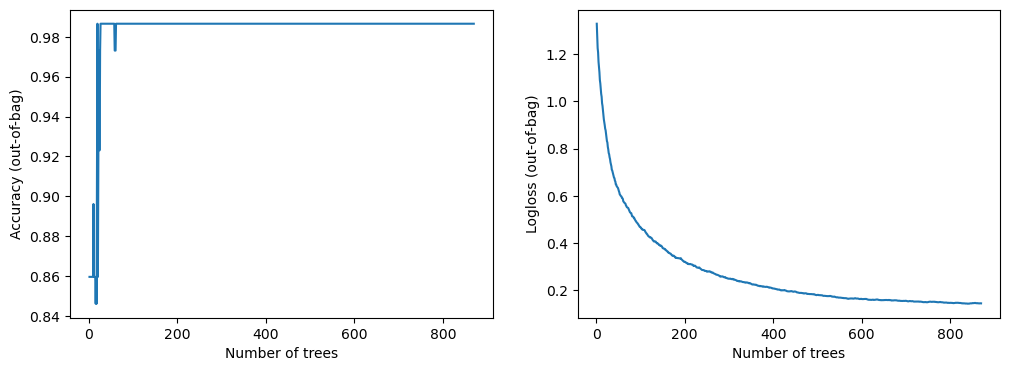


Train: 0.3571 Validation: 0.2744
##### Fold 7
Use /tmp/tmp1brwwbms as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:12.8125 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:12.8125 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:12.8126 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.246202. Found 555 examples.
Training model...
Model trained in 0:00:00.542651
Compiling model...


[INFO 23-07-21 07:53:14.6054 UTC kernel.cc:1242] Loading model from path /tmp/tmp1brwwbms/model/ with prefix 5cc8a7d2997d45b6
[INFO 23-07-21 07:53:14.6107 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.2420


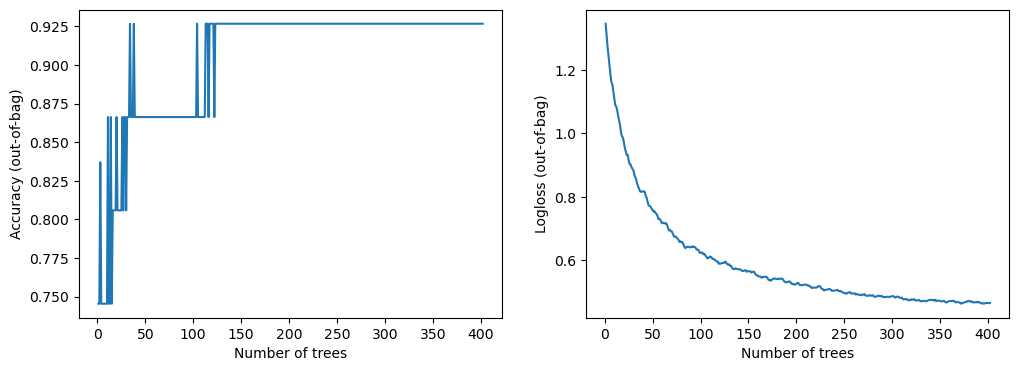


Train: 0.4262 Validation: 0.2420
##### Fold 8
Use /tmp/tmp_d87in5h as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:17.6717 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:17.6718 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:17.6718 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.228447. Found 556 examples.
Training model...
Model trained in 0:00:00.527260
Compiling model...


[INFO 23-07-21 07:53:19.4311 UTC kernel.cc:1242] Loading model from path /tmp/tmp_d87in5h/model/ with prefix f80d54c55a3b460b
[INFO 23-07-21 07:53:19.4366 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:53:19.4367 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.2632


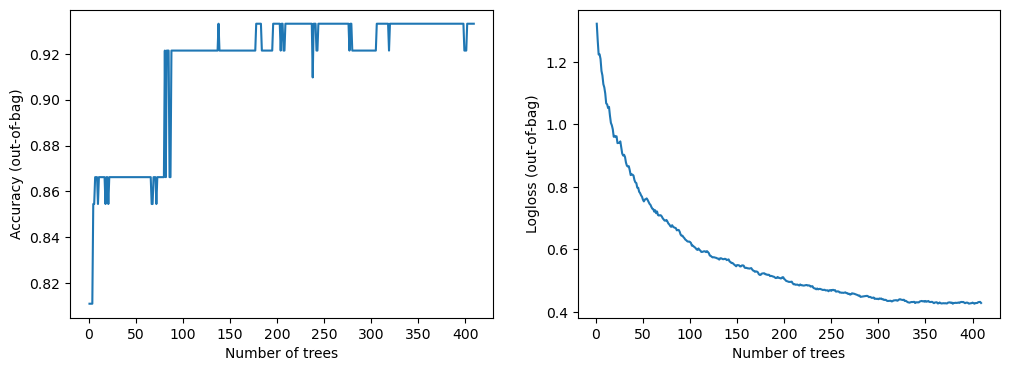


Train: 0.3848 Validation: 0.2632
##### Fold 9
Use /tmp/tmpcec6ml4k as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:22.5981 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:22.5982 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:22.5982 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.254676. Found 556 examples.
Training model...
Model trained in 0:00:00.719396
Compiling model...


[INFO 23-07-21 07:53:24.5732 UTC kernel.cc:1242] Loading model from path /tmp/tmpcec6ml4k/model/ with prefix 6335333edfe94944
[INFO 23-07-21 07:53:24.5808 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8852 - balanced_log_loss: 0.3122


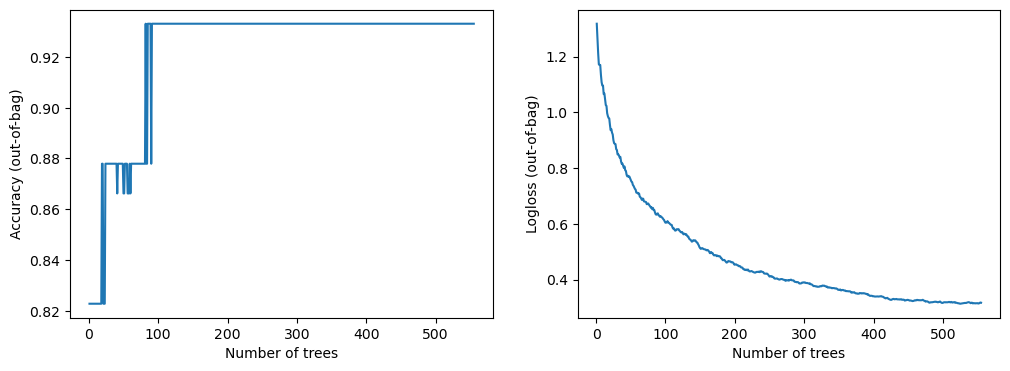


Train: 0.3803 Validation: 0.3122
##### Fold 10
Use /tmp/tmpd6q_z1b5 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 07:53:28.5855 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:28.5855 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 07:53:28.5855 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.273791. Found 556 examples.
Training model...
Model trained in 0:00:00.563466
Compiling model...


[INFO 23-07-21 07:53:30.4254 UTC kernel.cc:1242] Loading model from path /tmp/tmpd6q_z1b5/model/ with prefix 870bde2318854230
[INFO 23-07-21 07:53:30.4314 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 07:53:30.4314 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1399


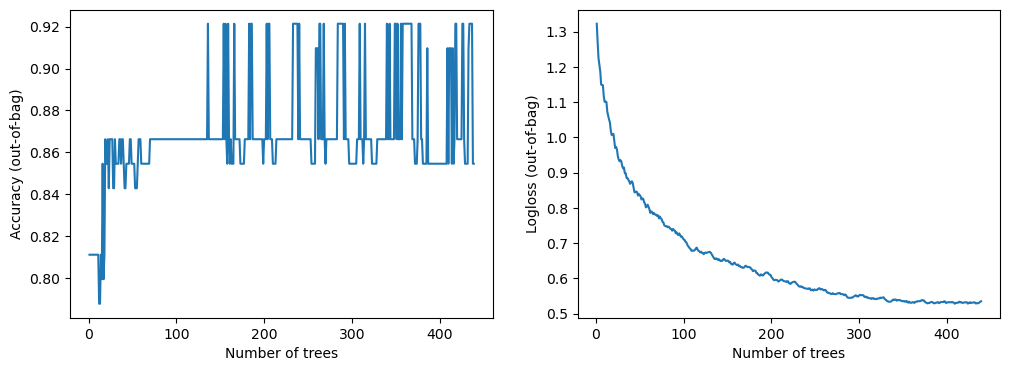


Train: 0.4631 Validation: 0.1399

Train mean: 0.3551 std: 0.1051

Validation mean: 0.2420 std: 0.0670


In [20]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

train_summary_gbt_2, valid_summary_gbt_2, test_summary_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# TabPFN

In [36]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.zeros((len(test.index),1)),index=test.index)
    train_summary = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics


def train_model_tabpfn_cv(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.zeros((len(train.index),n_splits)), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_summary = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(test[features])[:,1]
            
            # Predict Values
            train_summary.loc[train_ids, i] = p_train
            valid_summary.loc[valid_ids, 0] = p_val
            test_summary[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return train_summary, valid_summary, test_summary, models,metrics

In [35]:
# TabPFN tabpfn_
if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,submition=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [37]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Ensemble CV

# Ensemble Classes

# Submission

In [43]:
# Aggragate Subs

RF_m = pd.Series(metrics_rf_3['val']).mean()
GBT_m = pd.Series(metrics_gbt_2['val']).mean()
TabPFN_m = pd.Series(metrics_tabpfn_2['val']).mean()

print('RF: metric ', RF_m)
print('GBT: metric ', GBT_m)
print('TabPFN: metric ', TabPFN_m)

Total_m = GBT_m + RF_m + TabPFN_m

RF_w = 2/10
GBT_w = 4.5/10
TabPFN_w = 3.5/10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

RF: metric  0.30964104533195497
GBT: metric  0.24200911670923234
TabPFN: metric  0.25747682209169853
RF weight:  0.2
GBT weight:  0.45
TabPFN weight:  0.35


In [44]:
submition_total = pd.concat([test_summary_rf_3.mean(axis=1).to_frame("RF"),
                             test_summary_gbt_2.mean(axis=1).to_frame("GBT"),
                             test_summary_tabpfn_2.mean(axis=1).to_frame("TabPFN")]
                            ,axis=1)

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

In [45]:
# submition_total
submition_total = submition_total[['Ensemble']].copy()
submition_total.columns = ['class_1']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']]
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [46]:
submition_total

,class_0,class_1
Id,,
00eed32682bb,0.379512,0.620488
010ebe33f668,0.379512,0.620488
02fa521e1838,0.379512,0.620488
040e15f562a2,0.379512,0.620488
046e85c7cc7f,0.379512,0.620488


In [47]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float32
 1   class_1  5 non-null      float32
dtypes: float32(2)
memory usage: 80.0+ bytes
